In [0]:
N from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


img_size = 96
img_channels = 3

no_of_samples = 80000 # the number of images from each class

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir proj

In [0]:
!unzip "/content/drive/My Drive/histopathologic-cancer-detection.zip" -d "/content/proj"

Streaming output truncated to the last 5000 lines.
  inflating: /content/proj/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: /content/proj/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: /content/proj/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: /content/proj/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: /content/proj/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: /content/proj/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: /content/proj/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: /content/proj/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: /content/proj/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: /content/proj/train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: /content/proj/train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: /content/proj/train/fa2ebf31ff5954570526d4835ac5368fabc1

In [0]:
print(len(os.listdir('/content/proj/train')))
print(len(os.listdir('/content/proj/test')))

220025
57458


In [0]:

df_data = pd.read_csv('/content/proj/train_labels.csv')



print(df_data.shape)


(220025, 2)


In [0]:
df_data['label'].value_counts()


0    130908
1     89117
Name: label, dtype: int64

In [0]:
Path= '/content/proj/train/' 


In [0]:
def draw_category_images(col_name,figure_cols, df, Path):
    
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories)))
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) 
        for j in range(0,figure_cols):
            file=Path + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()


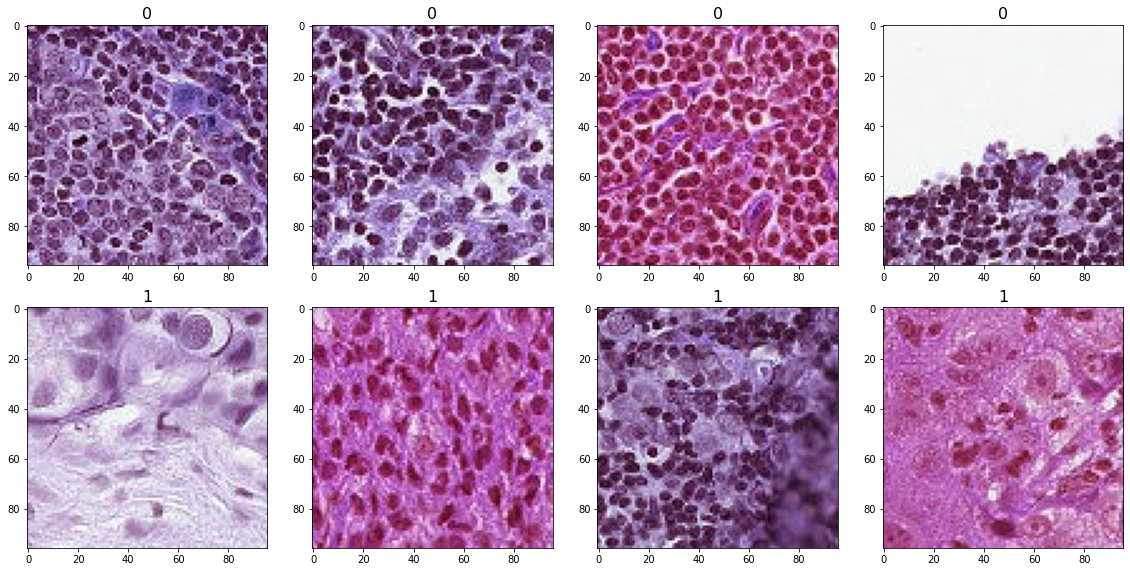

In [0]:
draw_category_images('label',4, df_data, Path)


In [0]:
df_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [0]:
df_0 = df_data[df_data['label'] == 0].sample(no_of_samples, random_state = 101)

df_1 = df_data[df_data['label'] == 1].sample(no_of_samples, random_state = 101)


df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [0]:
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)


(144000, 2)
(16000, 2)


In [0]:
df_train['label'].value_counts()


1    72000
0    72000
Name: label, dtype: int64

In [0]:
df_val['label'].value_counts()

1    8000
0    8000
Name: label, dtype: int64

In [0]:
main_dir = 'main_dir'
os.mkdir(main_dir)

In [0]:
train_dir = os.path.join(main_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(main_dir, 'val_dir')
os.mkdir(val_dir)


In [0]:
normal = os.path.join(train_dir, 'no_tumor')
os.mkdir(normal)
tumor = os.path.join(train_dir, 'has_tumor')
os.mkdir(tumor)


In [0]:
normal = os.path.join(val_dir, 'no_tumor')
os.mkdir(normal)
tumor= os.path.join(val_dir, 'has_tumor')
os.mkdir(tumor)

In [0]:
os.listdir('main_dir/train_dir')


['has_tumor', 'no_tumor']

In [0]:
df_data.set_index('id', inplace=True)


In [0]:
train_imgs = list(df_train['id'])
val_imgs = list(df_val['id'])


In [0]:
for image in train_imgs:
    
    
    fname = image + '.tif'
    target = df_data.loc[image,'label']
    
    
    if target == 0:
        label = 'no_tumor'
    if target == 1:
        label = 'has_tumor'
    
    src = os.path.join('/content/proj/train', fname)
    
    dst = os.path.join(train_dir, label, fname)
    
    shutil.copyfile(src, dst)


In [0]:
for image in val_imgs:
    
    
    fname = image + '.tif'
    
    target = df_data.loc[image,'label']
    
  
    if target == 0:
        label = 'no_tumor'
    if target == 1:
        label = 'has_tumor'
    

    
    src = os.path.join('/content/proj/train', fname)
    
    dst = os.path.join(val_dir, label, fname)
    
    shutil.copyfile(src, dst)


In [0]:
train_path = 'main_dir/train_dir'
valid_path = 'main_dir/val_dir'
test_path = '/content/proj/test'

no_train_samples = len(df_train)
no_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32


train_steps = np.ceil(no_train_samples / train_batch_size)
val_steps = np.ceil(no_val_samples / val_batch_size)


In [0]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(img_size,img_size),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')


test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)


Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [0]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        3

In [0]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])


In [0]:
print(val_gen.class_indices)

{'has_tumor': 0, 'no_tumor': 1}


In [0]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
4500/4500 [==============================] - 358s 80ms/step - loss: 0.4461 - accuracy: 0.7960 - val_loss: 0.5451 - val_accuracy: 0.7582 - lr: 1.0000e-04
Epoch 2/20
4500/4500 [==============================] - 338s 75ms/step - loss: 0.3589 - accuracy: 0.8443 - val_loss: 0.4127 - val_accuracy: 0.8171 - lr: 1.0000e-04
Epoch 3/20
4500/4500 [==============================] - 338s 75ms/step - loss: 0.3133 - accuracy: 0.8660 - val_loss: 0.3318 - val_accuracy: 0.8619 - lr: 1.0000e-04
Epoch 4/20
4500/4500 [==============================] - 339s 75ms/step - loss: 0.2866 - accuracy: 0.8794 - val_loss: 0.3726 - val_accuracy: 0.8422 - lr: 1.0000e-04
Epoch 5/20
4500/4500 [==============================] - 337s 75ms/step - loss: 0.2665 - accuracy: 0.8906 - val_loss: 0.2713 - val_accuracy: 0.8919 - lr: 1.0000e-04
Epoch 6/20
4500/4500 [==============================] - 337s 75ms/step - loss: 0.2514 - accuracy: 0.8975

In [0]:
model.metrics_names


['loss', 'accuracy']

In [0]:
val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)


Instructions for updating:
Please use Model.evaluate, which supports generators.
val_loss: 0.18447592854499817
val_acc: 0.9273124933242798


In [0]:
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
16000/16000 [==============================] - 61s 4ms/step


In [0]:
predictions.shape


(16000, 2)

In [0]:
df_preds = pd.DataFrame(predictions, columns=['normal', 'tumor'])

df_preds.head()


,normal,tumor
0,0.999938,0.000062
1,0.999964,0.000036
2,0.131271,0.868729
3,0.986351,0.013649
4,0.999769,0.000231


In [0]:
y_true = test_gen.classes


y_pred = df_preds['tumor']

In [0]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)


0.9808584687499999

In [0]:
test_labels = test_gen.classes


In [0]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [0]:
cm_plot_labels = ['normal', 'tumor']

print(cm)

[[7575  425]
 [ 738 7262]]


In [0]:
from sklearn.metrics import classification_report

y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)


              precision    recall  f1-score   support

      normal       0.91      0.95      0.93      8000
       tumor       0.94      0.91      0.93      8000

    accuracy                           0.93     16000
   macro avg       0.93      0.93      0.93     16000
weighted avg       0.93      0.93      0.93     16000

